<a href="https://colab.research.google.com/github/bacchus00/deep-learning-submissions/blob/main/Tarea_3_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de Células Sanguíneas

En el proceso de diagnóstico de enfermedades, el estudio de la cantidad de células sanguíneas juega un papel importante para determinar factores que explican una enfermedad. En esta tarea, la idea es implementar el modelo de deep-learning más efectivo posible para clasificar células sanguíneas. Las clases de células sanguíneas son: [Eosinophil, Lymphocyte, Monocyte, Neutrophil]


Integrantes: Sebastián Contreras, Fran Zautzik

In [ ]:
#Instalamos el paquete gdown para poder descargar el dataset desde el gdrive
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Descargamos el dataset
import gdown
output = 'blood.zip'
gdown.download(id='1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3', output=output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3
To: /content/blood.zip
100%|██████████| 105M/105M [00:00<00:00, 238MB/s] 


'blood.zip'

In [ ]:
# Descomprimimos el dataset
!unzip blood.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: images/TRAIN/MONOCYTE/_0_4446.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4528.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_453.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4560.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4563.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4650.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4667.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4715.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4745.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4762.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4778.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4791.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4862.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4872.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4881.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4884.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4925.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_494.jpeg  
  inflating: images/TRAIN/MONOCYTE/

Implementa la mejor red neuronal posible. Tú decides si usas una red creada por ti mismo o si empleas transfer-learning. Entrena la red con los datos en la carpeta "TRAIN" y usa los datos en "VAL" como validación.

Para medir el performance final, realiza las inferencias sobre los datos del conjunto "TEST" y computa el accuracy sobre el conjunto de test. El accuracy es la proporción de imágenes para las cuales la predicción es correcta. IMPORTANTE: el accuracy de test se calcula una sola vez cuando hayas finalizado todos tus experimentos. Para tomar decisiones sobre el modelo y sus hiperparámetros solo puedes usar el conjunto de entrenamiento y validación.

Detalla todos los experimentos que hiciste y cómo llegaste a la mejor red neuronal reportada. Discute los resultados, comparando los distintos experimentos que tomaste en cuenta y responde a la pregunta: Porqué tu modelo final fue el mejor de todo lo que probaste?

IMPORTANTE: Evita el overfitting a toda costa. Un modelo con overfitting es aquel que durante el entrenamiento las curvas de loss/accuracy para datos de entrenamiento y validación se separan considerablemente.

Éxitos!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import os
import copy
import random
from torchvision.io import read_image
from PIL import Image

In [ ]:
SEED = 666

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Preparación de la Data

In [ ]:
import os

def to_txt(data_type):
  # folder path
  dir_path = 'images'
  classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
  # list to store files
  data = []
  # Iterate directory
  for data_class in classes:
    for file in os.listdir(dir_path+'/'+data_type+'/'+data_class):
      # check only text files
      data.append(f'{data_class}/{file} {data_class}')

  file = open(f"images/{data_type}_split.txt", "w+")
  # Saving the array in a text file
  data = '\n'.join(data)
  file.write(data)
  file.close()

dataset_type = ['TEST', 'TRAIN', 'VAL']
for data_type in dataset_type:
  to_txt(data_type)


In [ ]:
class BloodDataset(torch.utils.data.Dataset):
  def __init__(self, root, split, transform):
    self.root = root
    self.split = split
    self.transform = transform
    self.class2idx = dict()

    self.class2idx['EOSINOPHIL'] = 0
    self.class2idx['LYMPHOCYTE'] = 1
    self.class2idx['MONOCYTE'] = 2
    self.class2idx['NEUTROPHIL'] = 3


    self.classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
    dataset_file = os.path.join(self.root, f'{self.split}_split.txt')
    with open(dataset_file, 'r') as f:
      lines = f.readlines()

    self.images = []
    self.labels = []

    for line in lines:
      line = line.strip()
      output = line.split(' ')
      self.images.append(output[0])
      self.labels.append(output[1])

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    path = [self.root, self.split, self.images[idx]]
    image_path = '/'.join(path)
    image = Image.open(image_path)
    label = self.class2idx[self.labels[idx]]
    im = image.convert('RGB')

    if self.transform:
      image = self.transform(im)

    return image, label

In [ ]:
train_dataset = BloodDataset(root='images', split='TRAIN',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225])
                                                ]))
test_dataset = BloodDataset(root='images', split = 'TEST',
                                              transform=transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                         std=[0.229, 0.224, 0.225])
                                                ]))

val_dataset = BloodDataset(root='images', split = 'VAL',
                                              transform=transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                         std=[0.229, 0.224, 0.225])
                                                ]))

print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

9957
2487
71


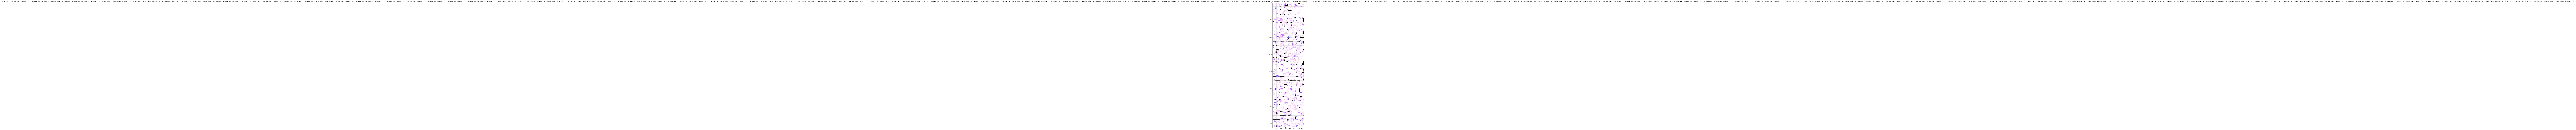

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=True)

class_names = train_dataset.classes

def imshow(inp, title = None):
  plt.figure(figsize=(10,20))
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.5])
  std = np.array([0.5])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)

  if title is not None:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

device = ('cuda' if torch.cuda.is_available() else 'cpu')

# Entrenamineto y Evaluación

In [ ]:
def train_model(model, train_dataset, val_dataset, criterion, optimizer, scheduler, num_epochs = 25):
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=True)

  train_loss_by_epoch = np.zeros(num_epochs)
  train_acc_by_epoch = np.zeros(num_epochs)
  valid_loss_by_epoch = np.zeros(num_epochs)
  valid_acc_by_epoch = np.zeros(num_epochs)

  best_valid_loss = float('inf')

  since = time.time()



  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)

    #Train model
    scheduler.step()
    model.train()

    running_loss = 0.0
    running_corrects = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    train_loss_by_epoch[epoch] = running_loss /len(train_dataset)
    train_acc_by_epoch[epoch] = running_corrects.double() / len(train_dataset)

    print('Train Loss: {:.4f} Acc: {:.4f}'.format(train_loss_by_epoch[epoch], train_acc_by_epoch[epoch]))

    #Validation
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0

    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    valid_loss_by_epoch[epoch] = running_loss /len(val_dataset)
    valid_acc_by_epoch[epoch] = running_corrects.double() / len(val_dataset)

    print('Val Loss: {:.4f} Acc: {:.4f}'.format(valid_loss_by_epoch[epoch], valid_acc_by_epoch[epoch]))

    if valid_acc_by_epoch[epoch] > best_acc:
        best_acc = valid_acc_by_epoch[epoch]
        best_model_wts = copy.deepcopy(model.state_dict())

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
  print('Best valdation accuracy: {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model, train_loss_by_epoch, train_acc_by_epoch, valid_loss_by_epoch, valid_acc_by_epoch

In [ ]:
def evaluate(test_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in test_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)

        loss = criterion(y_predicted, y_val)
        cumulative_loss += loss

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        data_count += y_val.shape[0]

    val_loss = cumulative_loss / data_count
    val_acc = cumulative_predictions / data_count

    return val_acc

In [ ]:
def visualize_model(model, num_images = 6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far +=1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
  model.train(mode = was_training)

# Ploteo

In [ ]:
def plot_curves(train_loss_by_epoch, valid_loss_by_epoch, train_acc_by_epoch, valid_acc_by_epoch, title_tail=''):
  fig, ax = plt.subplots(1, 2, figsize=(13, 5))
  fig.set_facecolor('white')

  epochs = np.arange(len(train_loss_by_epoch))

  ax[0].plot(epochs, train_loss_by_epoch, label='training')
  ax[0].plot(epochs, valid_loss_by_epoch, label='validation')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Loss evolution during training epochs'+'\n'+title_tail)
  ax[0].legend()

  ax[1].plot(epochs, train_acc_by_epoch, label='training')
  ax[1].plot(epochs, valid_acc_by_epoch, label='validation')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title('Accuracy evolution during training epochs'+'\n'+title_tail)
  ax[1].legend()

  plt.show()

  return fig, ax

# Experimentos

Para abordar el problema se realizaron una serie de experimentos en los que se probaron distintas formas de entrenamiento usando como base el modelo pre-entrenado resnet18. La estrategia general a seguir fue realizar entrenamientos modificando diferentes aspectos del modelo y luego elegir la versión que muestra el mejor desempeño para luego ocupar ese como base para el siguiente experimento.

El modelo base se adapta en su última capa para clasificar las 4 clases del problema. Inicialmente se entrena usando CrossEntropyLoss como función de pérdida, SGD como optimizador con un learning rate de $0.001$ y momentum de $0.9$ ya que son los métodos más básicos y estándar vistos en clases.

## Experimento 1: Freeze vs Fine-tuning

El primer experimento consta en comparar el desempeño del modelo al solo entrenar la capa fully connected final para clasificacion y el desempeño de entrenar toda la red con los nuevos ejemplos.

In [ ]:
# Freeze
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
  param.requires_grad = False

num_ft = model.fc.in_features
model.fc = nn.Linear(num_ft,4)

model = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.fc.parameters(), lr = 0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma = 0.1)

model, train_loss, train_acc, val_loss, val_acc  = train_model(model, train_dataset, val_dataset, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Loss: 1.4082 Acc: 0.2920
Val Loss: 1.2585 Acc: 0.4507
Epoch 1/24
----------
Train Loss: 1.2543 Acc: 0.4368
Val Loss: 1.0852 Acc: 0.5775
Epoch 2/24
----------
Train Loss: 1.1718 Acc: 0.4972
Val Loss: 1.0111 Acc: 0.7042
Epoch 3/24
----------
Train Loss: 1.1175 Acc: 0.5407
Val Loss: 0.9885 Acc: 0.6901
Epoch 4/24
----------
Train Loss: 1.0938 Acc: 0.5424
Val Loss: 0.9468 Acc: 0.7183
Epoch 5/24
----------
Train Loss: 1.0597 Acc: 0.5595
Val Loss: 0.8617 Acc: 0.8028
Epoch 6/24
----------
Train Loss: 1.0436 Acc: 0.5731
Val Loss: 0.8942 Acc: 0.7465
Epoch 7/24
----------
Train Loss: 1.0457 Acc: 0.5683
Val Loss: 0.8887 Acc: 0.7746
Epoch 8/24
----------
Train Loss: 1.0310 Acc: 0.5808
Val Loss: 0.8721 Acc: 0.7746
Epoch 9/24
----------
Train Loss: 1.0321 Acc: 0.5779
Val Loss: 0.8766 Acc: 0.7746
Epoch 10/24
----------
Train Loss: 1.0255 Acc: 0.5808
Val Loss: 0.8797 Acc: 0.7606
Epoch 11/24
----------
Train Loss: 1.0310 Acc: 0.5795
Val Loss: 0.8742 Acc: 0.7746
Epoch 12/24
----------
Train Loss: 1

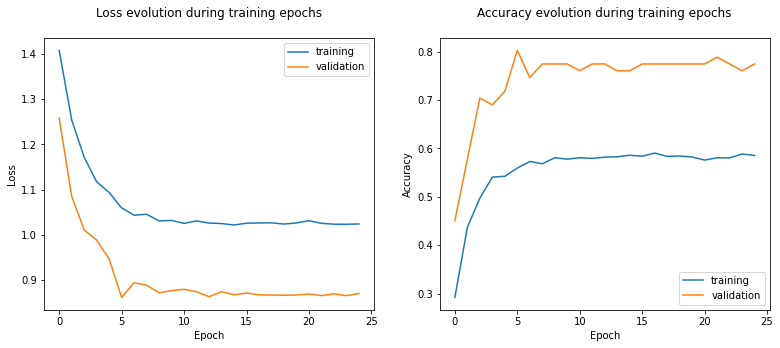

Test accuracy: 0.5954965822275834


In [ ]:
#Load the best model
plot_curves(train_loss, val_loss, train_acc, val_acc)
print('Test accuracy:', evaluate(test_loader, model, criterion, True))

In [ ]:
# Fine-Tuning
model_ft = models.resnet18(pretrained=True)
num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


model_ft, train_loss, train_acc, val_loss, val_acc  = train_model(model_ft, train_dataset, val_dataset, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Loss: 1.3135 Acc: 0.3741
Val Loss: 1.0078 Acc: 0.6338
Epoch 1/24
----------
Train Loss: 0.9012 Acc: 0.6433
Val Loss: 0.5283 Acc: 0.8028
Epoch 2/24
----------
Train Loss: 0.6493 Acc: 0.7452
Val Loss: 0.4522 Acc: 0.8592
Epoch 3/24
----------
Train Loss: 0.5201 Acc: 0.7902
Val Loss: 0.3520 Acc: 0.8732
Epoch 4/24
----------
Train Loss: 0.4629 Acc: 0.8123
Val Loss: 0.3521 Acc: 0.8873
Epoch 5/24
----------
Train Loss: 0.4006 Acc: 0.8380
Val Loss: 0.3464 Acc: 0.8873
Epoch 6/24
----------
Train Loss: 0.3929 Acc: 0.8360
Val Loss: 0.3394 Acc: 0.8873
Epoch 7/24
----------
Train Loss: 0.3982 Acc: 0.8342
Val Loss: 0.3449 Acc: 0.9014
Epoch 8/24
----------
Train Loss: 0.3889 Acc: 0.8439
Val Loss: 0.3385 Acc: 0.9014
Epoch 9/24
----------
Train Loss: 0.3860 Acc: 0.8442
Val Loss: 0.3353 Acc: 0.9014
Epoch 10/24
----------
Train Loss: 0.3863 Acc: 0.8433
Val Loss: 0.3365 Acc: 0.9014
Epoch 11/24
----------
Train Loss: 0.3900 Acc: 0.8412
Val Loss: 0.3417 Acc: 0.9014
Epoch 12/24
----------
Train Loss: 0

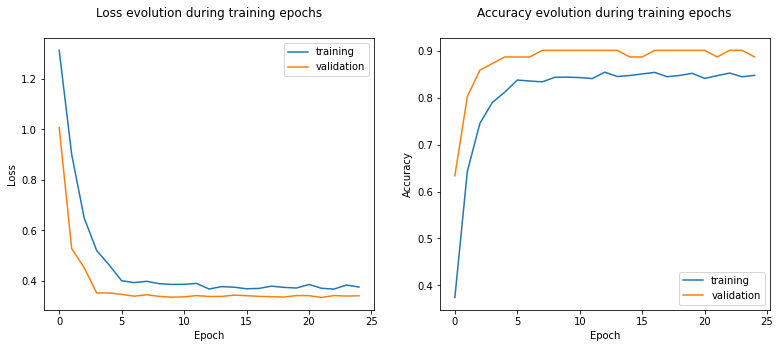

Test accuracy: 0.8584640128669079


In [ ]:
plot_curves(train_loss, val_loss, train_acc, val_acc)
print('Test accuracy:', evaluate(test_loader, model_ft, criterion, True))

De las curvas de aprendizaje es posible notar que para el caso en el que se congelaron los pesos, las curvas resultantes de entrenamiento y validación son más separadas que en el caso donde se entrena toda la red. En cuanto al desempeño resultante en el conjunto de test, se puede ver que para el caso en el que se congelan los pesos el accuracy es de alrededor de $0.60$, valor mucho inferior al obtenido para el caso en que se hace fine-tuning a toda la red, donde se obtuvo un accuracy en test de alrededor de $0.85$. Con lo anterior se determina que para este problema es preferible entrenar toda la red que congelar los pesos de las primeras capas.

## Experimento 2: Variando el Optimizador

El segundo experimento consta en ocupar distitntos optimizadores. Además de SGD, visto en el experimento anterior, se probó utilizando como alternativa el optimizador Adam y su variación AdamW.

In [ ]:
# Adam
model_ft = models.resnet18(pretrained=True)
num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


model_ft, train_loss, train_acc, val_loss, val_acc  = train_model(model_ft, train_dataset, val_dataset, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Loss: 0.6080 Acc: 0.7507
Val Loss: 0.4142 Acc: 0.8732
Epoch 1/24
----------
Train Loss: 0.3075 Acc: 0.8732
Val Loss: 0.4596 Acc: 0.8592
Epoch 2/24
----------
Train Loss: 0.2494 Acc: 0.9012
Val Loss: 0.7458 Acc: 0.7465
Epoch 3/24
----------
Train Loss: 0.2250 Acc: 0.9102
Val Loss: 0.5540 Acc: 0.8169
Epoch 4/24
----------
Train Loss: 0.2204 Acc: 0.9132
Val Loss: 0.3528 Acc: 0.8873
Epoch 5/24
----------
Train Loss: 0.1851 Acc: 0.9284
Val Loss: 0.5208 Acc: 0.8592
Epoch 6/24
----------
Train Loss: 0.1388 Acc: 0.9446
Val Loss: 0.5124 Acc: 0.8732
Epoch 7/24
----------
Train Loss: 0.1244 Acc: 0.9482
Val Loss: 0.5112 Acc: 0.8732
Epoch 8/24
----------
Train Loss: 0.1119 Acc: 0.9562
Val Loss: 0.6695 Acc: 0.8732
Epoch 9/24
----------
Train Loss: 0.1189 Acc: 0.9535
Val Loss: 0.6292 Acc: 0.8732
Epoch 10/24
----------
Train Loss: 0.1023 Acc: 0.9595
Val Loss: 0.6795 Acc: 0.8451
Epoch 11/24
----------
Train Loss: 0.0991 Acc: 0.9610
Val Loss: 0.6497 Acc: 0.8732
Epoch 12/24
----------
Train Loss: 0

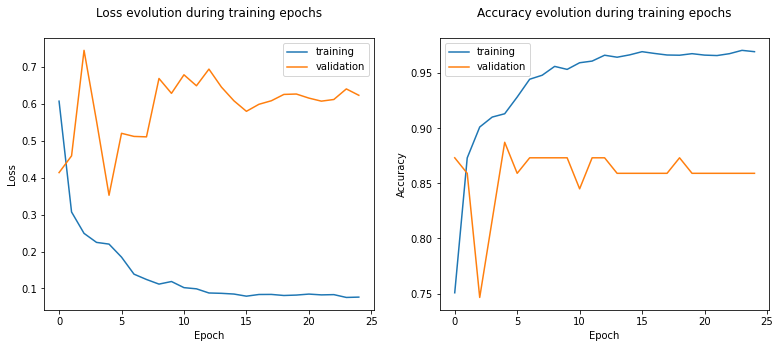

Test accuracy: 0.8238841978287093


In [ ]:
plot_curves(train_loss, val_loss, train_acc, val_acc)
print('Test accuracy:', evaluate(test_loader, model_ft, criterion, True))

In [ ]:
# AdamW
model_ft = models.resnet18(pretrained=True)
num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


model_ft, train_loss, train_acc, val_loss, val_acc = train_model(model_ft, train_dataset, val_dataset, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Loss: 0.5594 Acc: 0.7570
Val Loss: 0.4886 Acc: 0.8451
Epoch 1/24
----------
Train Loss: 0.3003 Acc: 0.8768
Val Loss: 0.5797 Acc: 0.8310
Epoch 2/24
----------
Train Loss: 0.2378 Acc: 0.9012
Val Loss: 1.6116 Acc: 0.6620
Epoch 3/24
----------
Train Loss: 0.2027 Acc: 0.9191
Val Loss: 0.4742 Acc: 0.8451
Epoch 4/24
----------
Train Loss: 0.2104 Acc: 0.9179
Val Loss: 1.1370 Acc: 0.7465
Epoch 5/24
----------
Train Loss: 0.1938 Acc: 0.9222
Val Loss: 0.3298 Acc: 0.9014
Epoch 6/24
----------
Train Loss: 0.1388 Acc: 0.9441
Val Loss: 0.3509 Acc: 0.9155
Epoch 7/24
----------
Train Loss: 0.1270 Acc: 0.9506
Val Loss: 0.3717 Acc: 0.9014
Epoch 8/24
----------
Train Loss: 0.1056 Acc: 0.9583
Val Loss: 0.3365 Acc: 0.9437
Epoch 9/24
----------
Train Loss: 0.1051 Acc: 0.9574
Val Loss: 0.3967 Acc: 0.9296
Epoch 10/24
----------
Train Loss: 0.0958 Acc: 0.9633
Val Loss: 0.2391 Acc: 0.9296
Epoch 11/24
----------
Train Loss: 0.0904 Acc: 0.9634
Val Loss: 0.5367 Acc: 0.9155
Epoch 12/24
----------
Train Loss: 0

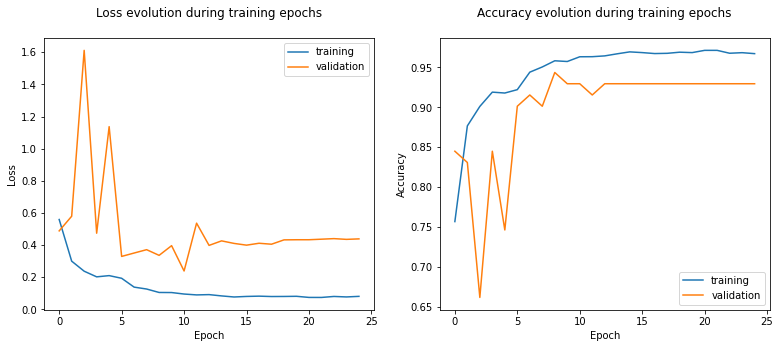

Test accuracy: 0.8841978287092883


In [ ]:
plot_curves(train_loss, val_loss, train_acc, val_acc)
print('Test accuracy:',evaluate(test_loader, model_ft, criterion, True))

Observando las curvas de aprendizaje es posible notar que en el caso de Adam y AdamW las curvas en el dataset de validacion oscilan bastante mas que en el caso de SGD. En cuanto al desempeño, para el caso de SGD se obtuvo un mejor accuracy en el conjunto de testing ($0.86$) que en el caso de Adam ($0.82$). Sin embargo, para el caso de AdamW el accuracy sobre el cojunto de test fue superior dando cerca de $0.88$. Con lo anterior se opta por continuar ocupando AdamW debido a que obtuvo el mejor desempeño.

## Experimento 3: Data Augmentation

En este experimento se estudió el efecto de hacer data augmentation sobre el data set original. En el primer caso se intento hacerlo manualmente invirtiendo el sentido de algunas imágenes y desplazando ligeramente las imágenes para luego intentar con el AutoAugmentPolicy  de IMAGENET con el que cuenta la libreria de torchvision. Esto se hizo teniendo en mente que podría ayudar al modelo a generalizar de mejor manera.

In [ ]:
train_dataset_aug = BloodDataset(root='images', split='TRAIN',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.RandomHorizontalFlip(), #inversion del sentido
                                                    transforms.Lambda(lambda x: x + torch.randn(3, 1, 1) * 0.05), #desplazamiento
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225]),
                                                ]))

In [ ]:
# Data Augmentation
model_ft = models.resnet18(pretrained=True)
num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


model_ft, train_loss, train_acc, val_loss, val_acc  = train_model(model_ft, train_dataset_aug, val_dataset, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Train Loss: 0.6801 Acc: 0.7075
Val Loss: 0.8155 Acc: 0.7042
Epoch 1/24
----------
Train Loss: 0.3654 Acc: 0.8471
Val Loss: 0.2199 Acc: 0.9155
Epoch 2/24
----------
Train Loss: 0.3003 Acc: 0.8732
Val Loss: 0.7366 Acc: 0.8169
Epoch 3/24
----------
Train Loss: 0.2811 Acc: 0.8823
Val Loss: 0.4800 Acc: 0.9014
Epoch 4/24
----------
Train Loss: 0.2444 Acc: 0.8981
Val Loss: 0.8865 Acc: 0.8028
Epoch 5/24
----------
Train Loss: 0.2222 Acc: 0.9102
Val Loss: 0.7661 Acc: 0.8451
Epoch 6/24
----------
Train Loss: 0.1916 Acc: 0.9218
Val Loss: 0.5583 Acc: 0.8873
Epoch 7/24
----------
Train Loss: 0.1617 Acc: 0.9336
Val Loss: 0.5230 Acc: 0.8873
Epoch 8/24
----------
Train Loss: 0.1408 Acc: 0.9440
Val Loss: 0.5858 Acc: 0.8732
Epoch 9/24
----------
Train Loss: 0.1317 Acc: 0.9465
Val Loss: 0.5274 Acc: 0.8732
Epoch 10/24
----------
Train Loss: 0.1252 Acc: 0.9491
Val Loss: 0.6747 Acc: 0.8732
Epoch 11/24
----------
Train Loss: 0.1245 Acc: 0.9504
Val Loss: 0.5724 Acc: 0.9014
Epoch 12/24
--

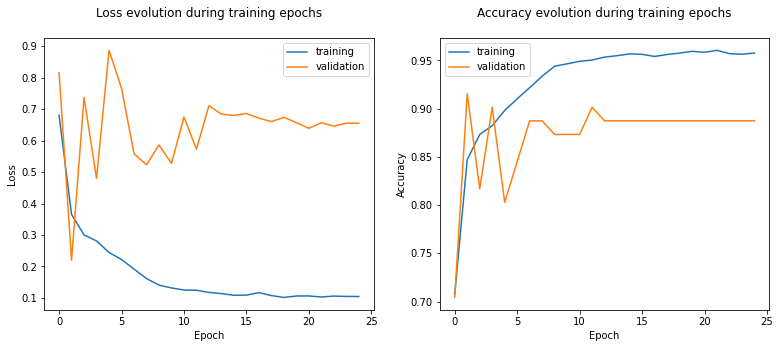

Test accuracy: 0.8387615601125854


In [ ]:
plot_curves(train_loss, val_loss, train_acc, val_acc)
print('Test accuracy:', evaluate(test_loader, model_ft, criterion, True))

In [ ]:
train_dataset_aug = BloodDataset(root='images', split='TRAIN',
                                                transform=transforms.Compose([
                                                    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225]),
                                                ]))

In [ ]:
# Data Augmentation
model_ft = models.resnet18(pretrained=True)
num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


model_ft, train_loss, train_acc, val_loss, val_acc  = train_model(model_ft, train_dataset_aug, val_dataset, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Train Loss: 0.9520 Acc: 0.5911
Val Loss: 0.6654 Acc: 0.7324
Epoch 1/24
----------
Train Loss: 0.5819 Acc: 0.7506
Val Loss: 0.3575 Acc: 0.8451
Epoch 2/24
----------
Train Loss: 0.4849 Acc: 0.7934
Val Loss: 0.7816 Acc: 0.7465
Epoch 3/24
----------
Train Loss: 0.4256 Acc: 0.8214
Val Loss: 0.3483 Acc: 0.8732
Epoch 4/24
----------
Train Loss: 0.3951 Acc: 0.8364
Val Loss: 0.5810 Acc: 0.8451
Epoch 5/24
----------
Train Loss: 0.3521 Acc: 0.8509
Val Loss: 0.3756 Acc: 0.8732
Epoch 6/24
----------
Train Loss: 0.3072 Acc: 0.8729
Val Loss: 0.3819 Acc: 0.9014
Epoch 7/24
----------
Train Loss: 0.2585 Acc: 0.8939
Val Loss: 0.3728 Acc: 0.9014
Epoch 8/24
----------
Train Loss: 0.2429 Acc: 0.9004
Val Loss: 0.5458 Acc: 0.9155
Epoch 9/24
----------
Train Loss: 0.2301 Acc: 0.9053
Val Loss: 0.4185 Acc: 0.9014
Epoch 10/24
----------
Train Loss: 0.2204 Acc: 0.9089
Val Loss: 0.5779 Acc: 0.9014
Epoch 11/24
----------
Train Loss: 0.2020 Acc: 0.9192
Val Loss: 0.5169 Acc: 0.9155
Epoch 12/24
--

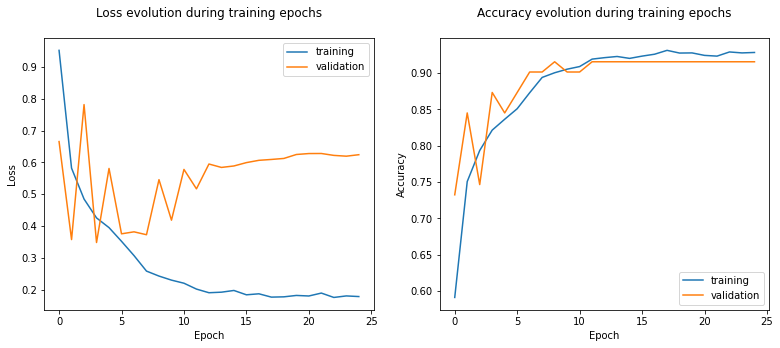

Test accuracy: 0.8395657418576599


In [ ]:
plot_curves(train_loss, val_loss, train_acc, val_acc)
print('Test accuracy:', evaluate(test_loader, model_ft, criterion, True))

Para ambos casos en los que se hizo data augmentation, tanto el policy como el hecho manualmente, se puede observar que el desempeño del modelo no logra superar el accuracy obtenido sin utilizar esta técnica sobre los datos de entrenamiento.

# Experimento 4: Dropout


Para este experimento se estudió el efecto de ocupar dropout con distintos valores de $p$ en la última capa de la red. Primero se intentó con una probabilidad de $0.25$ y luego con $0.5$

In [ ]:
# Dropout p=0.25
model_ft = models.resnet18(pretrained=True)
num_ft = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Dropout(p=0.25),
    nn.Linear(num_ft, 4),
)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


model_ft, train_loss, train_acc, val_loss, val_acc = train_model(model_ft, train_dataset, val_dataset, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Loss: 0.5792 Acc: 0.7536
Val Loss: 0.4853 Acc: 0.8732
Epoch 1/24
----------
Train Loss: 0.3159 Acc: 0.8696
Val Loss: 0.9226 Acc: 0.7746
Epoch 2/24
----------
Train Loss: 0.2597 Acc: 0.8958
Val Loss: 0.6144 Acc: 0.8169
Epoch 3/24
----------
Train Loss: 0.2300 Acc: 0.9084
Val Loss: 0.6770 Acc: 0.8310
Epoch 4/24
----------
Train Loss: 0.2077 Acc: 0.9155
Val Loss: 1.3184 Acc: 0.7324
Epoch 5/24
----------
Train Loss: 0.1904 Acc: 0.9229
Val Loss: 0.7478 Acc: 0.8451
Epoch 6/24
----------
Train Loss: 0.1444 Acc: 0.9421
Val Loss: 0.6113 Acc: 0.8873
Epoch 7/24
----------
Train Loss: 0.1217 Acc: 0.9505
Val Loss: 0.6457 Acc: 0.8732
Epoch 8/24
----------
Train Loss: 0.1124 Acc: 0.9555
Val Loss: 0.6229 Acc: 0.9014
Epoch 9/24
----------
Train Loss: 0.1019 Acc: 0.9602
Val Loss: 0.5985 Acc: 0.8873
Epoch 10/24
----------
Train Loss: 0.1035 Acc: 0.9607
Val Loss: 0.5627 Acc: 0.9014
Epoch 11/24
----------
Train Loss: 0.0964 Acc: 0.9616
Val Loss: 0.7029 Acc: 0.9014
Epoch 12/24
----------
Train Loss: 0

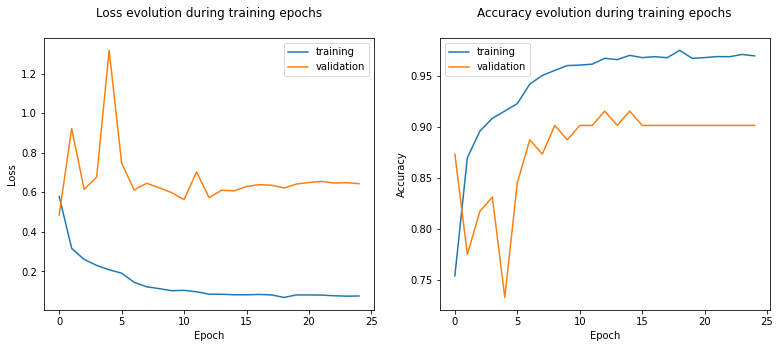

Test accuracy: 0.856453558504222


In [ ]:
plot_curves(train_loss, val_loss, train_acc, val_acc)
print('Test accuracy:', evaluate(test_loader, model_ft, criterion, True))

In [ ]:
# Dropout p=0.5
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ft, 4),
)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


model_ft, train_loss, train_acc, val_loss, val_acc = train_model(model_ft, train_dataset, val_dataset, criterion, optimizer, exp_lr_scheduler, num_epochs=25)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Loss: 0.6002 Acc: 0.7381
Val Loss: 0.9154 Acc: 0.6479
Epoch 1/24
----------
Train Loss: 0.3156 Acc: 0.8695
Val Loss: 1.1403 Acc: 0.7183
Epoch 2/24
----------
Train Loss: 0.2753 Acc: 0.8859
Val Loss: 0.5990 Acc: 0.8451
Epoch 3/24
----------
Train Loss: 0.2219 Acc: 0.9127
Val Loss: 0.8190 Acc: 0.8732
Epoch 4/24
----------
Train Loss: 0.2089 Acc: 0.9141
Val Loss: 0.8846 Acc: 0.8169
Epoch 5/24
----------
Train Loss: 0.1985 Acc: 0.9205
Val Loss: 1.2005 Acc: 0.8169
Epoch 6/24
----------
Train Loss: 0.1517 Acc: 0.9383
Val Loss: 0.5478 Acc: 0.9155
Epoch 7/24
----------
Train Loss: 0.1325 Acc: 0.9482
Val Loss: 0.5594 Acc: 0.9014
Epoch 8/24
----------
Train Loss: 0.1170 Acc: 0.9519
Val Loss: 0.5821 Acc: 0.8873
Epoch 9/24
----------
Train Loss: 0.1094 Acc: 0.9559
Val Loss: 0.5950 Acc: 0.9155
Epoch 10/24
----------
Train Loss: 0.1061 Acc: 0.9580
Val Loss: 0.6809 Acc: 0.8592
Epoch 11/24
----------
Train Loss: 0.0980 Acc: 0.9602
Val Loss: 0.5545 Acc: 0.8732
Epoch 12/24
----------
Train Loss: 0

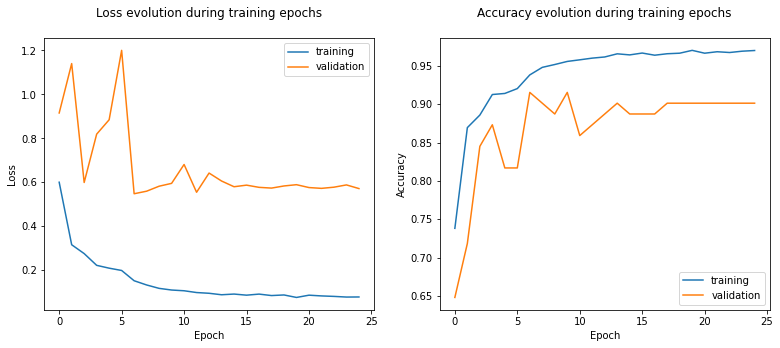

Test accuracy: 0.8339364696421391


In [ ]:
plot_curves(train_loss, val_loss, train_acc, val_acc)
print('Test accuracy:', evaluate(test_loader, model_ft, criterion, True))

Se puede observar que los accuracy en el conjunto de test obtenidos haciendo uso de dropout son inferiores a lo obtenido por la red sin uso de dropout, habiendo obtenido este último modelo $0.88$ y los modelos con drop out con $p=0.25$ y $p=0.5$ alrededor de $0.86$ y $0.83$ respectivamente.

# Conclusión

De los experimentos anteriores se determina que el mejor modelo encontrado es el que utiliza fine-tuning de toda la red, AdamW como optimizador, sin uso de data augmentation sobre los datos de entrenamiento ni dropout en la capa fully connected de salida, obteniendo un accuracy sobre conjunto de test de alrededor de $0.88$ para este problema de clasificación.

Es importante mencionar que si bien se variaron las metodologías de transfer learning, los optimizadores, el uso de data augmentation, la implementación de dropout en la capa fully connected para la implementación de la red neuronal existían más hiperparámetros que podían ser modificados para experimentar con el modelo creado.